<a href="https://colab.research.google.com/github/JUNYA-727/bitcoin_lightgbm_model/blob/main/lightgbm_btc_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install optuna

In [ ]:
#特徴量として使用するテクニカル指標の計算のライブラリ
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
!./configure --prefix=/usr
!make
!make install
!pip install Ta-Lib

In [50]:
import pandas as pd
import talib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import optuna.integration.lightgbm as lgb
import numpy as np

In [40]:
df1=pd.read_csv('/content/drive/MyDrive/btc 9月12日-11月26日.csv')
df1

,2021-09-12 14:45:00,45853.99,45857.72,45842.03,45857.72.1,0.8006
0,2021-09-12 15:00:00,45896.18,45896.18,45819.53,45819.53,0.500400
1,2021-09-12 15:15:00,45813.99,45813.99,45813.99,45813.99,0.010000
2,2021-09-12 15:45:00,45834.92,45834.92,45747.05,45747.05,1.760000
3,2021-09-12 16:00:00,45807.04,45881.14,45807.04,45881.14,0.018020
4,2021-09-12 16:15:00,45881.14,45881.14,45881.14,45881.14,1.278035
...,...,...,...,...,...,...
5994,2021-11-26 13:45:00,54293.16,54421.48,54276.06,54388.82,0.307000
5995,2021-11-26 14:00:00,54468.70,54591.47,54459.06,54591.47,0.459667
5996,2021-11-26 14:15:00,54731.51,54731.51,54559.06,54671.26,1.762644
5997,2021-11-26 14:30:00,54785.51,54933.69,54785.51,54933.69,0.651511


In [41]:
df2=pd.read_csv('/content/drive/MyDrive/btc 11月26日②　15分ごとデータ.csv')
df2

,2021/11/26 14:45,54903.12,55015.21,54894.46,54943.44,1.15184948
0,2021/11/26 15:00,54943.44,54947.27,54676.14,54947.27,0.015000
1,2021/11/26 15:15,54947.27,54947.27,54752.51,54752.51,0.666000
2,2021/11/26 15:30,54752.51,54752.51,54558.78,54697.05,0.632696
3,2021/11/26 15:45,54697.05,54702.35,54679.03,54702.35,0.465000
4,2021/11/26 16:00,54673.13,54673.13,54399.65,54429.49,8.795818
...,...,...,...,...,...,...
782,2021/12/6 4:00,49162.85,49162.85,49120.46,49120.46,0.610000
783,2021/12/6 4:30,49259.44,49259.44,49242.76,49242.76,0.104916
784,2021/12/6 4:45,49286.46,49286.46,49207.80,49207.80,0.056292
785,2021/12/6 5:00,49060.18,49060.18,49022.18,49022.18,0.011010


In [42]:
df1=df1.iloc[0:,4:5]
df1.columns=['price']
df2=df2.iloc[0:,4:5]
df2.columns=['price']

In [45]:
df3=pd.concat([df1,df2],axis=0).reset_index(drop=True)

In [46]:
# talibで特徴量を加える
#単純移動平均線　期間は10と20
df3['sma10']=talib.SMA(df3['price'],timeperiod=10)
df3['sma20']=talib.SMA(df3['price'],timeperiod=20)
#ボリンジャーバンド　期間は20で偏差は±2σ
up,middle,low=talib.BBANDS(df3['price'],timeperiod=20,nbdevdn=2,nbdevup=2,matype=0)
df3['bb_up']=up
df3['bb_low']=low
#MACD(移動平均収束拡散手法)､期間は12,26
macd,macdsignal,macdhist=talib.MACD(df3['price'],fastperiod=12,slowperiod=26,signalperiod=9)
df3['macd']=macd
df3['macdsignal']=macdsignal
df3['macdhist']=macdhist
#RSI(相対力指数)､期間は9､14
df3['rsi9']=talib.RSI(df3['price'],timeperiod=9)
df3['rsi14']=talib.RSI(df3['price'],timeperiod=14)
#モメンタム､期間は10
df3['mom']=talib.MOM(df3['price'],timeperiod=10)
#ストティキャスRSI
fastk,fastd=talib.STOCHRSI(df3['price'],timeperiod=14,fastk_period=5,fastd_period=3,fastd_matype=0)
df3['fastk']=fastk
df3['fastd']=fastd
#分散､期間は5
df3['var']=talib.VAR(df3['price'],timeperiod=5,nbdev=1)
#線形回帰､期間は14
df3['line']=talib.LINEARREG(df3['price'],timeperiod=14)
#線形回帰の角度､期間は14
df3['lineangle']=talib.LINEARREG_ANGLE(df3['price'],timeperiod=14)

In [47]:
df3=df3[33:].reset_index(drop=True)

In [51]:
price=np.array(df3["price"])
action=[]
#sellは0でbuyは1でラベル付け
for i in range(len(price)-2):
  new=price[i+2]-price[i+1]
  if 0<=new:
    action.append(1)
  else:
    action.append(0)
df=df3[1:-1].reset_index(drop=True)
df.insert(0,'action',action)
print(df['action'].value_counts())

0    3418
1    3333
Name: action, dtype: int64


In [ ]:
x=df.iloc[:,1:]
y=df.iloc[:,:1]
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,shuffle=False)
lgb_train=lgb.Dataset(x_train,y_train)
lgb_test=lgb.Dataset(x_test,y_test,reference=lgb_train)

param={
    'task':'train',
    'boosting_type':'gbdt',
    'obective':'binary',
    'verbose':'-1',
    'metric':'binary_error',
}
best=lgb.train(param,
              lgb_train,
              valid_sets=lgb_test,
              early_stopping_rounds=500,
              verbose_eval=False)
print(best.params)
print(best.best_iteration)
print(best.best_score)

In [80]:
score=(np.array(best.feature_importance())/np.sum(np.array(best.feature_importance())))
cols=list(x.columns)
importance=pd.DataFrame({'feature':cols,'importance':score})
importance

,feature,importance
0,price,0.019048
1,sma10,0.019048
2,sma20,0.047619
3,bb_up,0.033333
4,bb_low,0.028571
5,macd,0.057143
6,macdsignal,0.061905
7,macdhist,0.066667
8,rsi9,0.052381
9,rsi14,0.071429


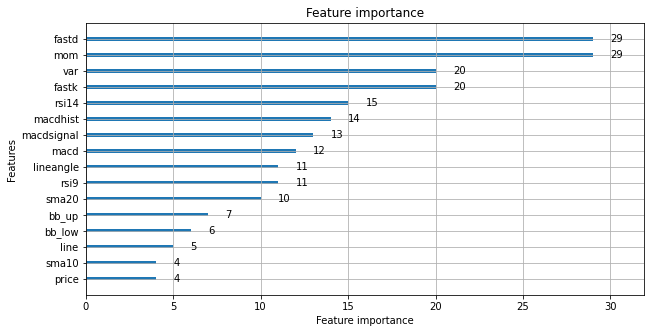

In [176]:
lgb.plot_importance(best,figsize=(10,5))
plt.savefig('/content1.png')

In [109]:
predict=best.predict(x_test,num_iteration=best.best_iteration)
test=y_test.values.tolist()
check=[]
#testデータで精度の確認
for i in range(len(predict)):
  if predict[i]>=0.5:
    check.append(1)
  else:
    check.append(0)
answer=[]
for i in range(len(y_test)):
  if test[i][0]==0:
    answer.append(0)
  else:
    answer.append(1)
game=[]
for i in range(len(answer)):
  if answer[i]==check[i]:
    game.append('win')
  else:
    game.append('lose')


print('予測とテストデータの一致した数:'+str(game.count('win')))
print('予測とテストデータの外した数:'+str(game.count('lose')))
print('sellを予測した数:'+str(check.count(0))+' buyを予測した数:'+str(check.count(1)))
print('実際のsellの数:'+str(answer.count(0))+'実際のbuyの数:'+str(answer.count(1)))

予測とテストデータの一致した数:741
予測とテストデータの外した数:610
sellを予測した数:584 buyを予測した数:767
実際のsellの数:718実際のbuyの数:633


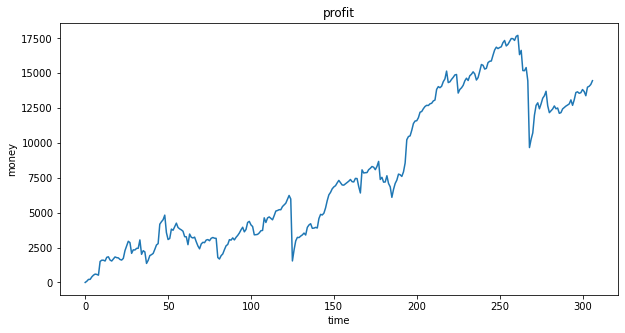

In [177]:
#testデータで実際の自動売買を行ってみて利益がどうなるか
price=np.array(x_test['price'])
money=[0]
#エントリーしているかの状態確認(1ならsellでエントリー､2ならbuyでエントリーしている状態を指す)
have=0
#いつエントリーしたかを格納しておく
sell_data=[]
buy_data=[]
#儲け
profit=0

for i in range(len(x_test)):
  #エントリーしていない状態の時
  if have==0:
    #sellでエントリー
    if check[i]==0:
      have=1
      sell_data.append(i)
      continue
    #buyでエントリー
    if check[i]==1:
      have=2
      buy_data.append(i)
      continue
  #売りでエントリーしている状態の時
  if have==1:
    #次もsellだと予測したら､保有
    if check[i]==0:
      continue
    #次がbuyだと予測したら､決済
    if check[i]==1:
      profit+=price[sell_data[-1]]-price[i]
      money.append(profit)
      have=0
      continue
  #買いでエントリーしている状態の時
  if have==2:
    #次もbuyだと予測したら､保有
    if check[i]==1:
      continue
    #次がsellだと予測したら､決済
    if check[i]==0:
      profit+=price[i]-price[buy_data[-1]]
      money.append(profit)
      have=0
      continue
plt.figure(figsize=(10,5))
plt.plot(money)    
plt.title('profit')
plt.xlabel('time')
plt.ylabel('money')
plt.savefig('/content2.png')
plt.show()

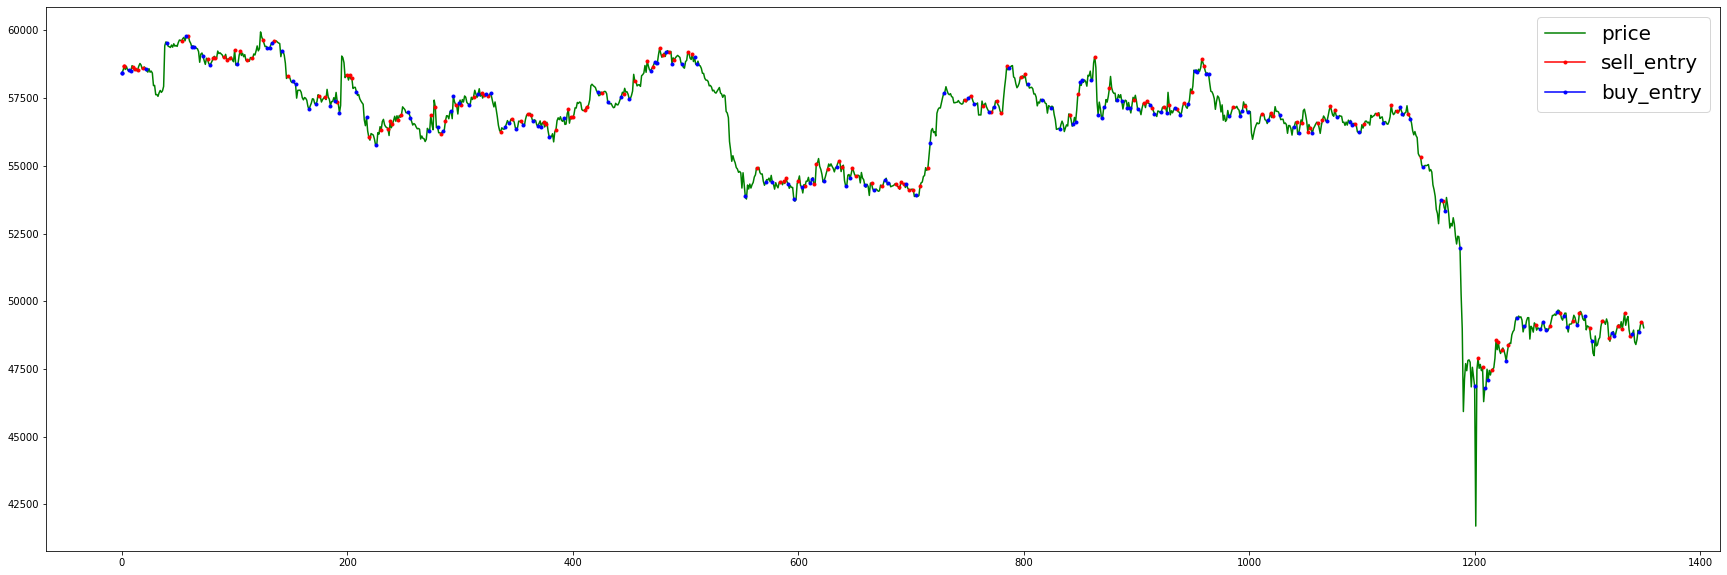

In [178]:
#どこでsellとbuyのエントリーをしているのか
plt.figure(figsize=(30,10))
plt.plot(price,color='green',label='price')
for i in sell_data:
  plt.plot(i,price[i],marker='.',color='red')
for j in buy_data:
  plt.plot(j,price[j],marker='.',color='blue')
plt.plot(sell_data[0],price[sell_data[0]],marker='.',color='red',label='sell_entry')
plt.plot(buy_data[0],price[buy_data[0]],marker='.',color='blue',label='buy_entry')
plt.legend(fontsize=20)
plt.savefig('/content3.png')
plt.show()

In [179]:
#モデルの保存　
import pickle
file = '/trained_model.pkl'
pickle.dump(best, open(file, 'wb'))

In [183]:
#モデルの読み込み(確認として)
gbm=pickle.load(open('/trained_model.pkl','rb'))
pred=gbm.predict(x_test)